# Practical work 3

Authors: ANNEN Rayane, MARTINS Alexis

## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import mlp_backprop_momentum as mlp
import scipy.io.wavfile as wav
import os
import k_fold_cross_validation as cv
import glob
from python_speech_features import mfcc

## Creating dataset

In [2]:
PATH = '/datasets/vowels/'

nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]
nk_audios = [wav.read(path) for path in nk_paths]

naf_mfcc_median = np.array([np.median(mfcc(audio, samplerate=samplerate, nfft=1024), axis= 0) for samplerate, audio in naf_audios])
nam_mfcc_median = np.array([np.median(mfcc(audio, samplerate=samplerate, nfft=1024), axis= 0) for samplerate, audio in nam_audios]) 
nak_mfcc_median = np.array([np.median(mfcc(audio, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, audio in nk_audios[::3]])

In [3]:
def normalize(data):
    x_min = data.min(axis=0)
    x_max = data.max(axis=0)
    normalized = (data - x_min)/(x_max - x_min)
    return normalized

In [4]:
def create_dataset(men, women, kids):
    dataset = normalize(np.concatenate((men, women, kids)))

    arr1 = np.array([[1, 0, 0]])
    arr2 = np.array([[0, 1, 0]])
    arr3 = np.array([[0, 0, 1]])

    arr1_block = np.repeat(arr1, 36, axis=0)
    arr2_block = np.repeat(arr2, 36, axis=0)
    arr3_block = np.repeat(arr3, 36, axis=0)
    
    arr_block = np.vstack((arr1_block, arr2_block, arr3_block))
    dataset = np.hstack((dataset, arr_block))

    return dataset

In [5]:
dataset = create_dataset(nam_mfcc_median, naf_mfcc_median, nak_mfcc_median)

In [6]:
N_INITS = 10
NB_EPOCHS = [100, 300, 600]
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.7

## Test du nombre d'epochs

In [7]:
epochs_testing = dict()

for EPOCHS in NB_EPOCHS:
    MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
    for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([13,h,3], 'tanh')
        for i in np.arange(N_INITS):                                        # looping over the initializations
            nn.init_weights()
            
            MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:16]),
                                    learning_rate=LEARNING_RATE,
                                    momentum=MOMENTUM,
                                    epochs=EPOCHS)
    epochs_testing[EPOCHS] = MSE

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


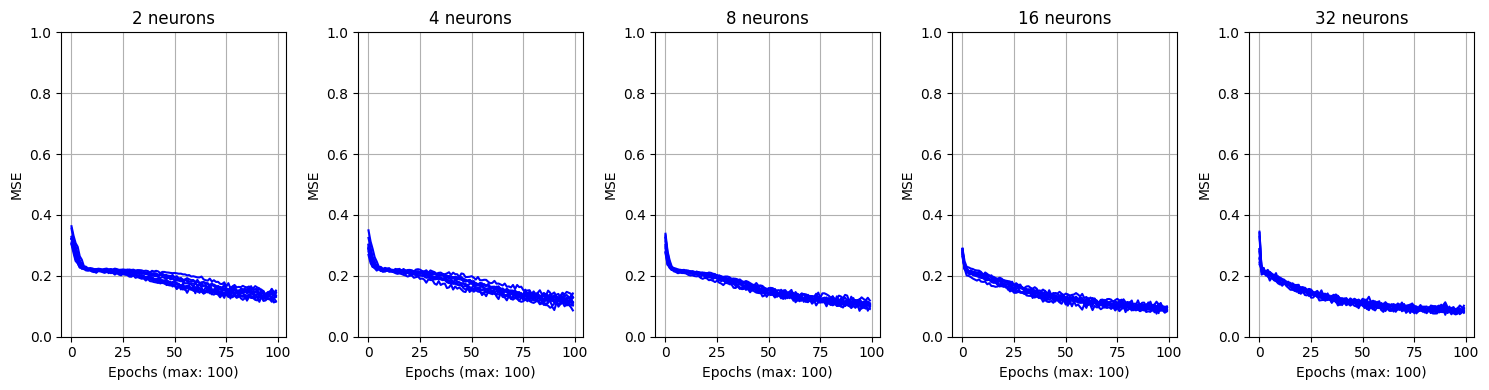

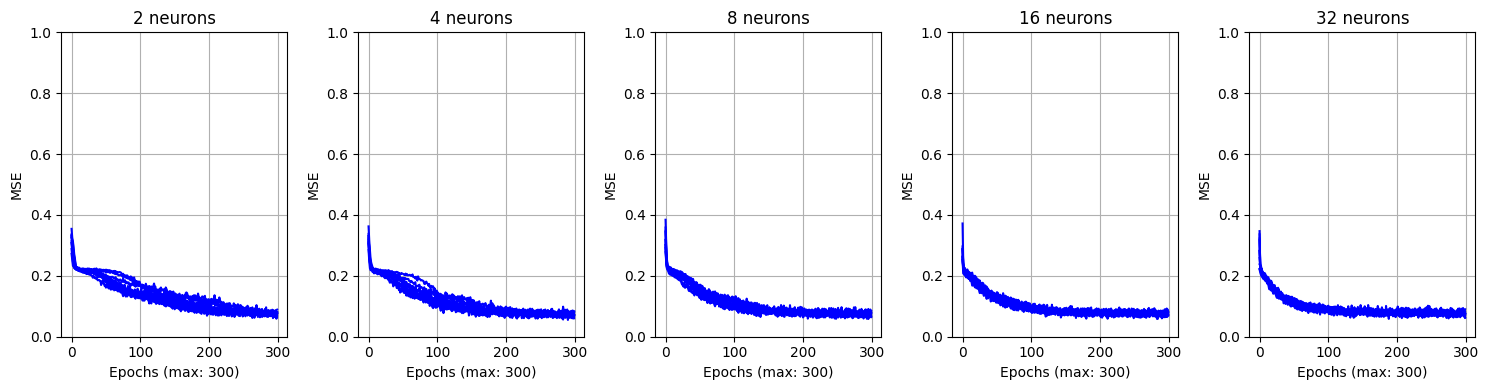

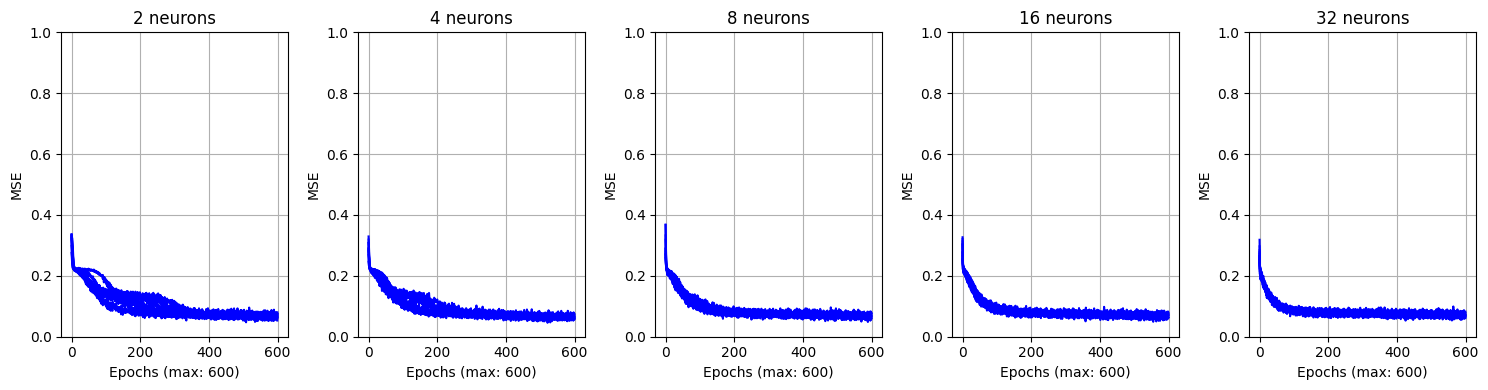

In [8]:
for EPOCHS, MSE in epochs_testing.items() :
    pl.figure(figsize=(15,4))
    for n in np.arange(MSE.shape[0]):
        pl.subplot(1, MSE.shape[0], n+1)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlabel(f'Epochs (max: {EPOCHS})')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
    pl.tight_layout()

## Test du nombre de neurones

In [9]:
EPOCHS = 300
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [10]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


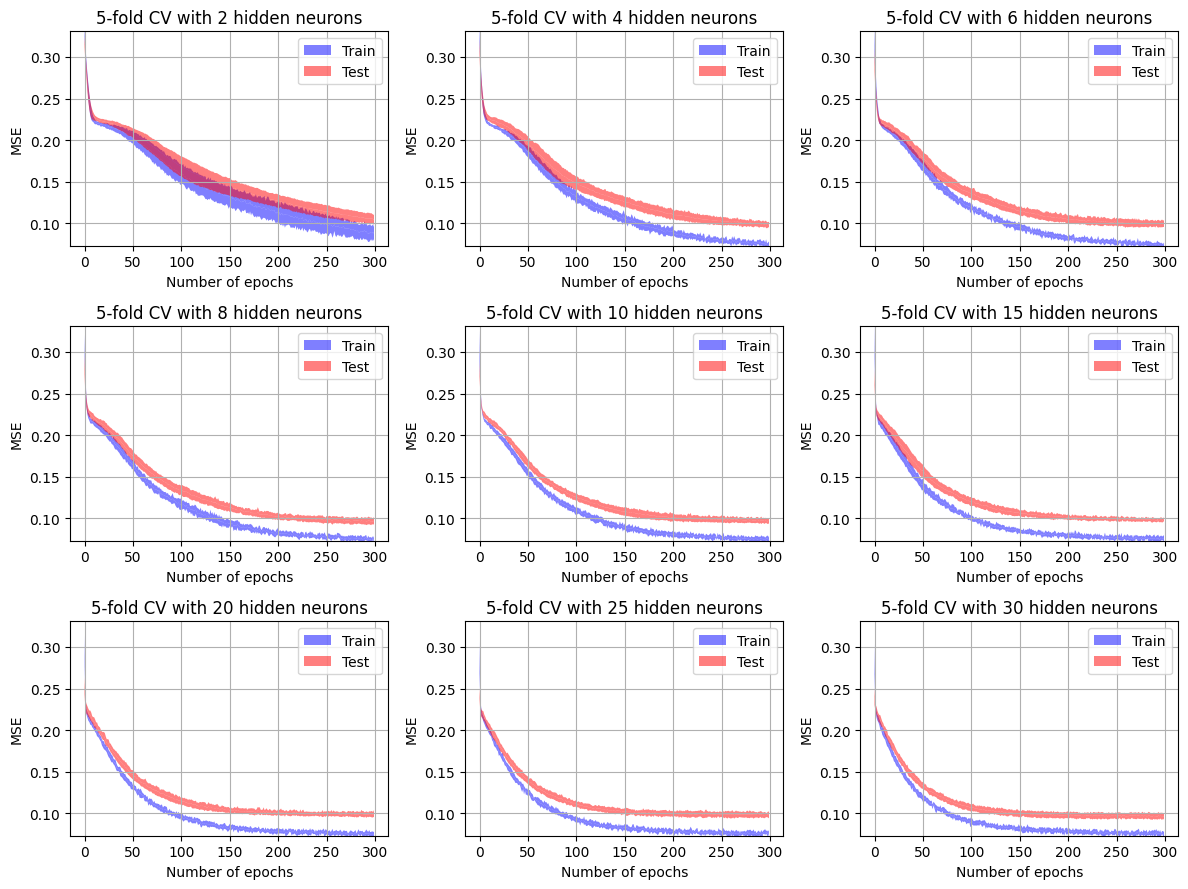

In [11]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min,v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

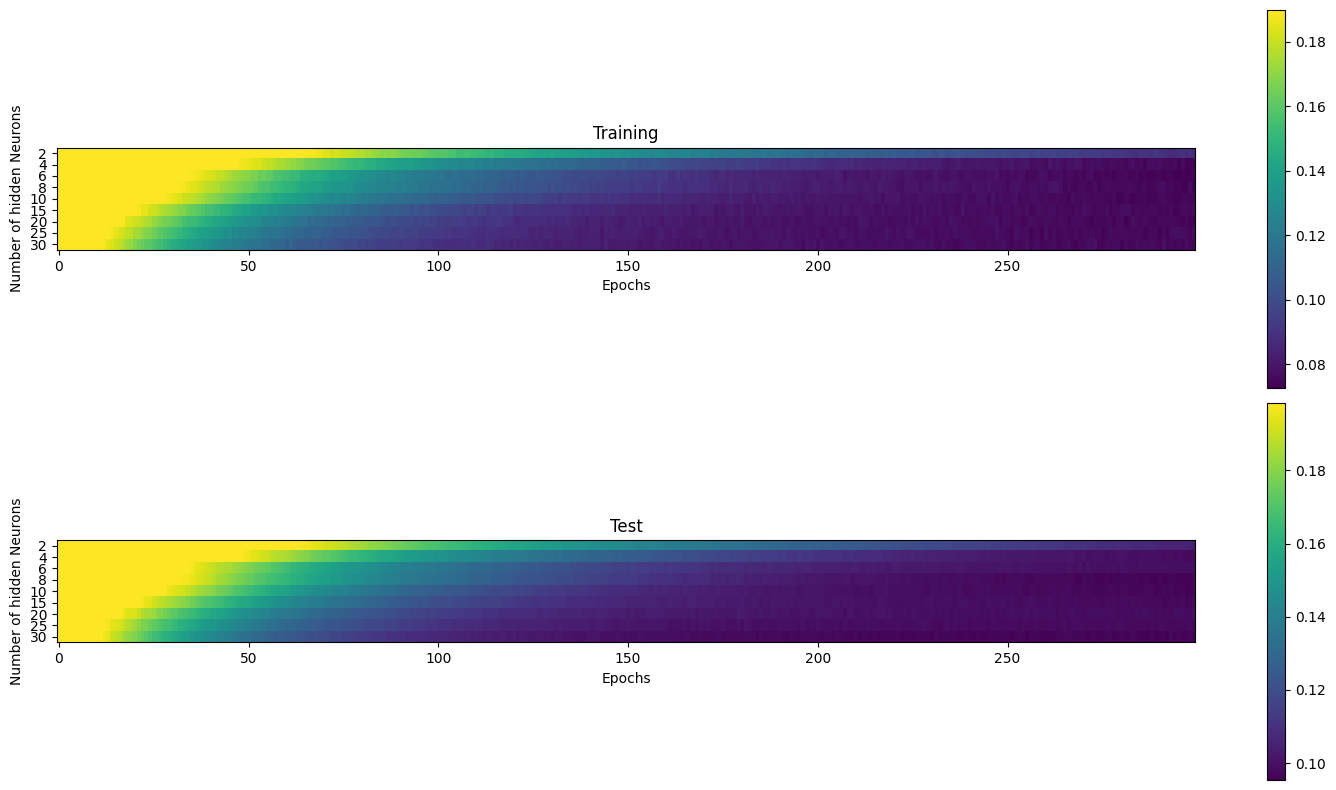

In [12]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## Modèle choisi

Après nos analyses, nous avons déterminé les hyperparamètres suivants :

- N_INITS = 10

- NB_EPOCHS = 300

- N_NEURONS = 8

- LEARNING_RATE = 0.001

- MOMENTUM = 0.7

- K = 5

- N_TESTS = 10

Ce sont ces valeurs qui nous ont données les meilleurs résultats tout au long des analyses. Il faut maintenant créer le modèle final avec tous ces hyperparamètres et tester ses performances.

In [13]:
N_INITS = 10
EPOCHS = 300
N_NEURONS = 8
LEARNING_RATE = 0.001
MOMENTUM = 0.7
K = 5


nn = mlp.MLP([13,N_NEURONS,3], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=EPOCHS,
                                                          threshold=0.5)

In [14]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = pl.subplots()
    im = ax.imshow(conf_matrix, cmap="viridis")

    classes_names = ['natural male', 'natural female', 'natural kids']

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(classes_names)), labels=classes_names)
    ax.set_yticks(np.arange(len(classes_names)), labels=classes_names)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes_names)):
        for j in range(len(classes_names)):
            text = ax.text(j, i, conf_matrix[i, j], fontweight="bold", fontsize="large", ha="center", va="center", c="r")

    fig.tight_layout()
    pl.show()

def calculate_f1_score(conf_mat):
    f1_scores = []
    for i in range(conf_mat.shape[0]):
        TP = conf_mat[i, i]
        FP = np.sum(conf_mat, axis=0)[i] - TP
        FN = np.sum(conf_mat, axis=1)[i] - TP
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1_score)
    print(f1_scores)
    weighted_f1_score = np.average(f1_scores, weights=np.sum(conf_mat, axis=1))
    return weighted_f1_score

MSE training:  0.07387820690042253
MSE test:  0.09631542486116738
[0.8947368421052632, 0.8055555555555555, 0.85]
F1-Score:  0.8524417769570123


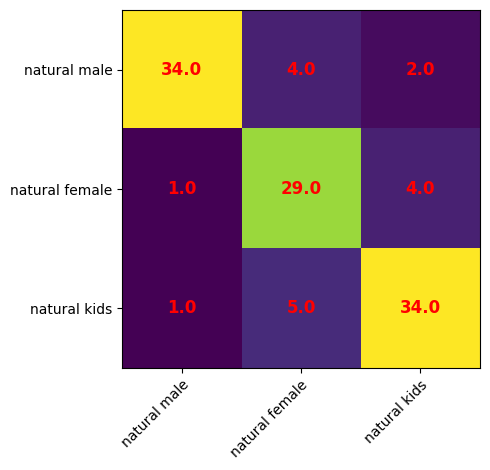

In [15]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('F1-Score: ', calculate_f1_score(conf_mat))
plot_confusion_matrix(conf_mat)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7369ba6d-4fc1-484b-a24b-97226e77125a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>